In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

### Generating example data

In [2]:
n_observations = 1000

true_orange_mu, true_orange_sd = 300, 100
true_green_mu, true_green_sd = 600, 200

# Fraction of each class that will be observed.
obs_pct_orange_mu, obs_pct_orange_sd = 0.10, 0.05
obs_pct_green_mu, obs_pct_green_sd = 0.40, 0.10

df = pd.DataFrame(
    dict(
        true_orange=np.random.normal(true_orange_mu, true_orange_sd, size=n_observations),
        true_green=np.random.normal(true_green_mu, true_green_sd, size=n_observations),
        pct_obs_orange=np.random.normal(obs_pct_orange_mu, obs_pct_orange_sd, size=n_observations),
        pct_obs_green=np.random.normal(obs_pct_green_mu, obs_pct_green_sd, size=n_observations),
    ),
    columns=['true_orange', 'true_green', 'pct_obs_orange', 'pct_obs_green']
)
df['total'] = df['true_orange'] + df['true_green']
df['obs_orange'] = df['true_orange'] * df['pct_obs_orange'].clip(lower=0)
df['obs_green'] = df['true_green'] * df['pct_obs_green'].clip(lower=0)

df.drop(['pct_obs_orange', 'pct_obs_green'], axis=1, inplace=True)
df = df.round().astype(int)
df

,true_orange,true_green,total,obs_orange,obs_green
0,372,721,1093,5,376
1,357,635,991,57,279
2,422,487,910,42,187
3,444,1153,1598,42,377
4,313,315,628,16,91
...,...,...,...,...,...
995,363,347,710,12,177
996,59,617,676,9,253
997,326,698,1024,29,414
998,237,305,542,6,117


## Model of process with PyMC

### Using only 10 observations

In [3]:
data_df_10 = df[:10]
data_df_10

,true_orange,true_green,total,obs_orange,obs_green
0,372,721,1093,5,376
1,357,635,991,57,279
2,422,487,910,42,187
3,444,1153,1598,42,377
4,313,315,628,16,91
5,256,158,414,6,59
6,322,425,746,53,179
7,351,516,866,32,177
8,297,1061,1359,23,227
9,246,480,726,36,129


In [4]:
with pm.Model() as m10:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_10),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_10['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_10['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_10['total']
    )
    
    trace_m10 = pm.sample(1_000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_orange, sd_orange, orange_daily, mu_green, sd_green, green_daily]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 518 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'orange_daily'}>,
        <Axes: title={'center': 'green_daily'}>,
        <Axes: title={'center': 'mu_orange'}>],
       [<Axes: title={'center': 'sd_orange'}>,
        <Axes: title={'center': 'mu_green'}>,
        <Axes: title={'center': 'sd_green'}>]], dtype=object)

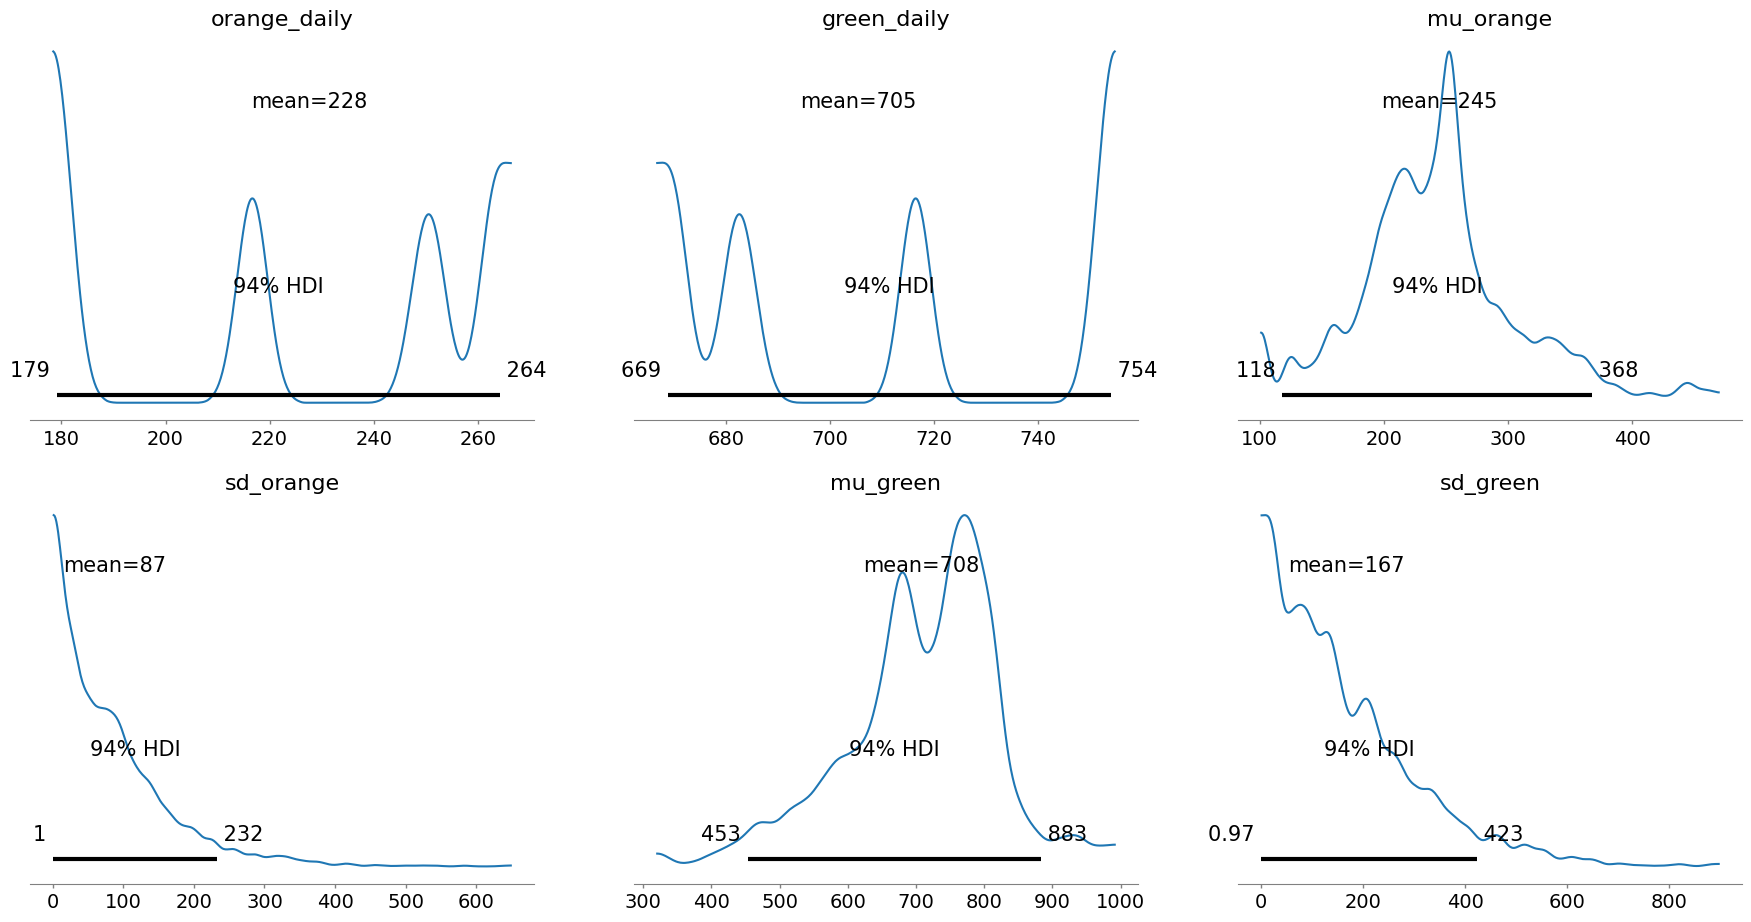

In [5]:
az.plot_posterior(trace_m10)

### With 100 observations

In [6]:
data_df_100 = df[:100]
data_df_100

,true_orange,true_green,total,obs_orange,obs_green
0,372,721,1093,5,376
1,357,635,991,57,279
2,422,487,910,42,187
3,444,1153,1598,42,377
4,313,315,628,16,91
...,...,...,...,...,...
95,257,981,1238,32,419
96,120,356,475,6,154
97,286,831,1118,27,352
98,345,834,1180,41,299


In [7]:
with pm.Model() as m100:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_100),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_100['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_100['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_100['total']
    )
    
    trace_m100 = pm.sample(1_000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_orange, sd_orange, orange_daily, mu_green, sd_green, green_daily]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 567 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'orange_daily'}>,
        <Axes: title={'center': 'green_daily'}>,
        <Axes: title={'center': 'mu_orange'}>],
       [<Axes: title={'center': 'sd_orange'}>,
        <Axes: title={'center': 'mu_green'}>,
        <Axes: title={'center': 'sd_green'}>]], dtype=object)

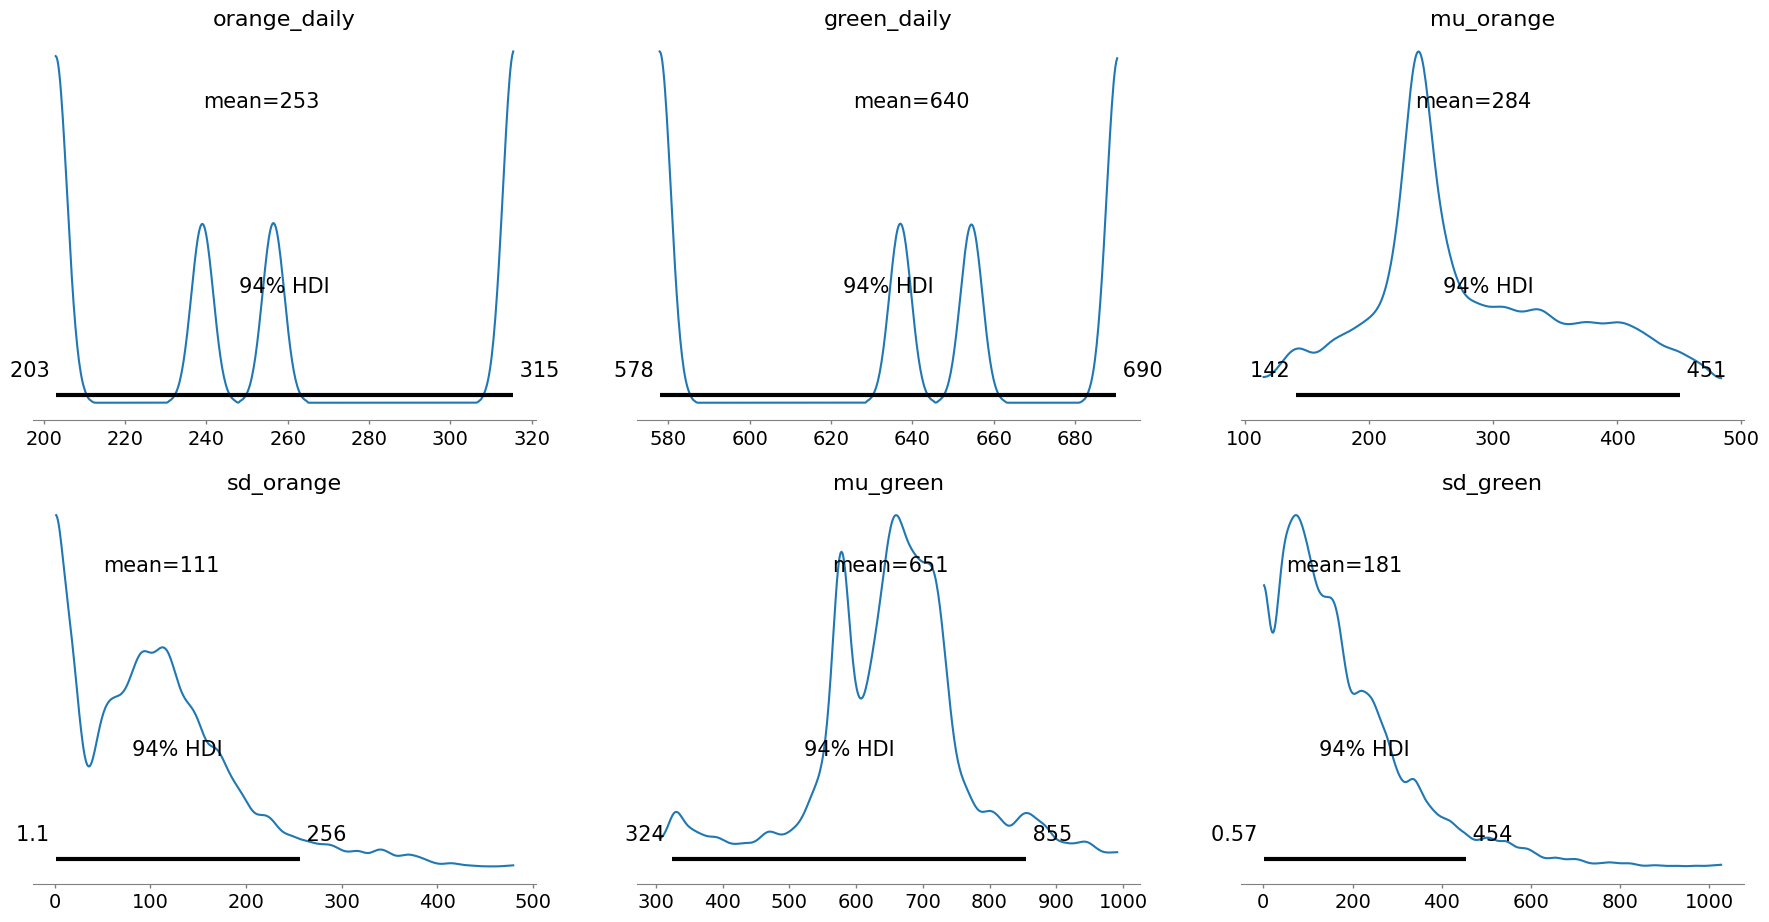

In [8]:
az.plot_posterior(trace_m100)

### With all 1000 observations

In [9]:
data_df_1000 = df[:1000]
data_df_1000

,true_orange,true_green,total,obs_orange,obs_green
0,372,721,1093,5,376
1,357,635,991,57,279
2,422,487,910,42,187
3,444,1153,1598,42,377
4,313,315,628,16,91
...,...,...,...,...,...
995,363,347,710,12,177
996,59,617,676,9,253
997,326,698,1024,29,414
998,237,305,542,6,117


In [10]:
with pm.Model() as m1000:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_1000),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_1000['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_1000['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_1000['total']
    )
    
    trace_m1000 = pm.sample(1_000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_orange, sd_orange, orange_daily, mu_green, sd_green, green_daily]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 729 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'orange_daily'}>,
        <Axes: title={'center': 'green_daily'}>,
        <Axes: title={'center': 'mu_orange'}>],
       [<Axes: title={'center': 'sd_orange'}>,
        <Axes: title={'center': 'mu_green'}>,
        <Axes: title={'center': 'sd_green'}>]], dtype=object)

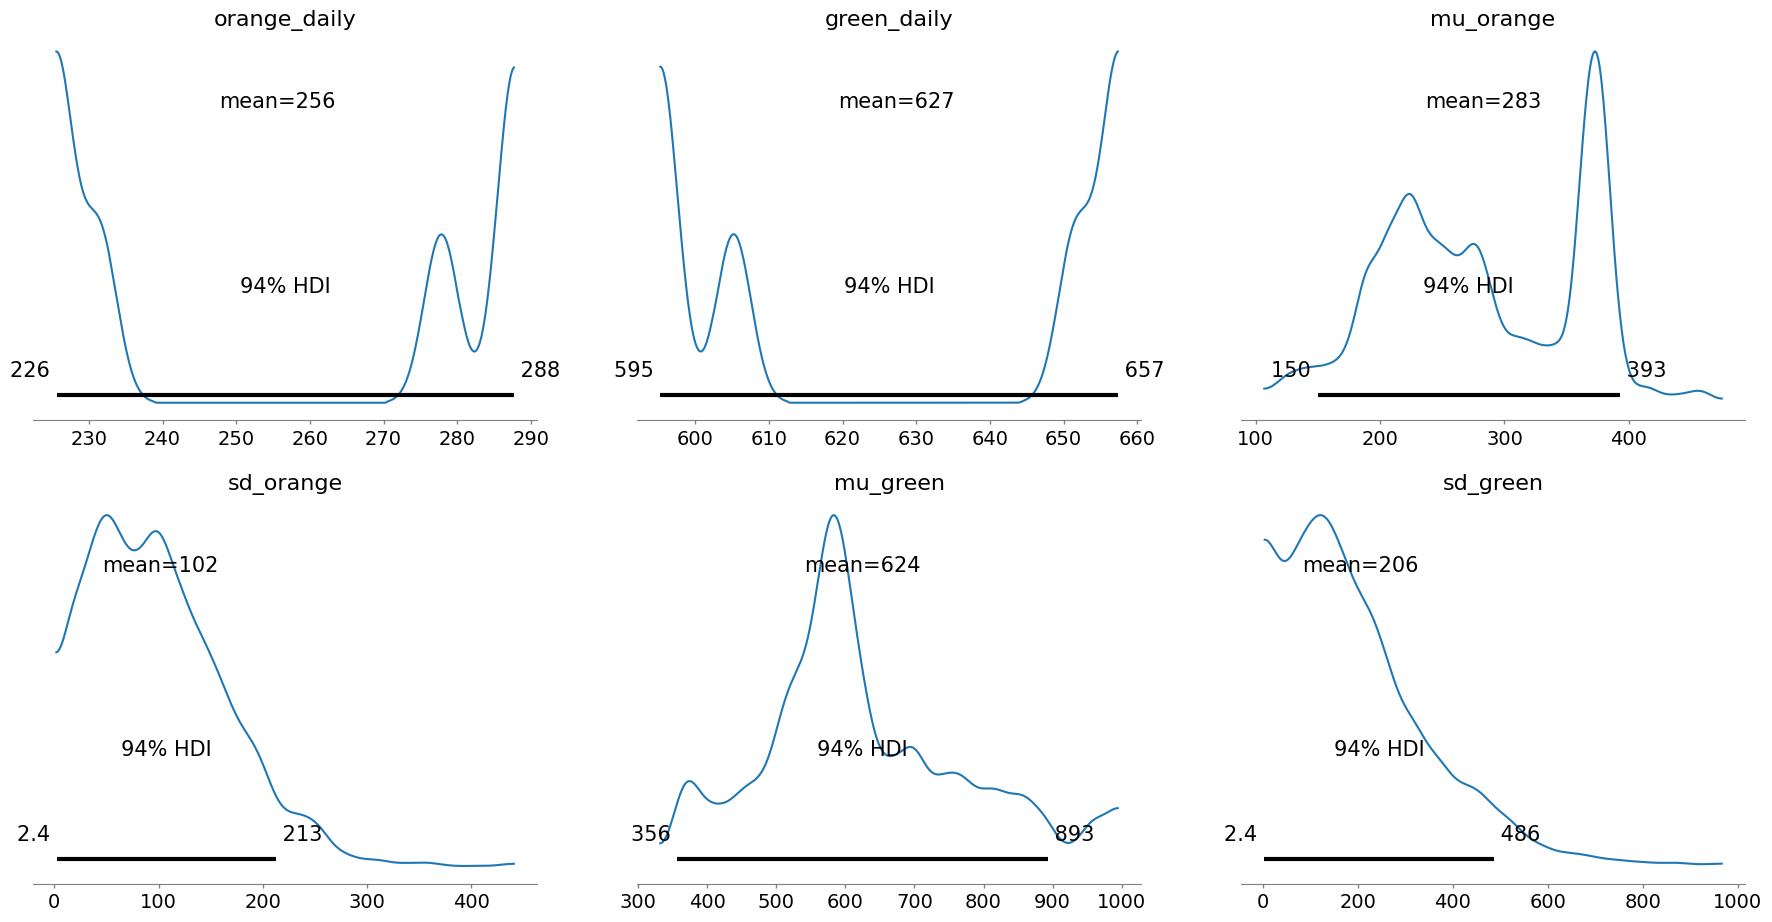

In [11]:
az.plot_posterior(trace_m1000)